In [ ]:
import pandas as pd
import json
import os
import ast
import matplotlib.pyplot as plt


In [2]:
LOCATIE_REQUESTS = os.path.join("../data/requests")
LOCATIE_RESPONSES = os.path.join("../data/responses")
RUWE_DATA_CSV = os.path.join('../data/ruw/all_ruwe_data.csv')
GEKREGEN_EXCEL_FILE = os.path.join('../data/ModifiedQueryRows.xlsx')

In [3]:
def parse_filename(file_name) -> tuple:
    try:
        # rsplit verwijdert alleen de laatste .json extensie (voor mocht het bestand meerdere .json bevatten alhoewel dit onwaarschijnlijk lijkt)
        parts = file_name.rsplit('.json', 1)[0].split('-')
        if len(parts) >= 5:
            route_id = parts[0]
            date = parts[1]
            time = parts[2]
            number_of_tasks = parts[3]
            number_of_tasks_in_input_plan = parts[4]
            return route_id, date, time, number_of_tasks, number_of_tasks_in_input_plan
        else:
            print(f"Skipping file {file_name}: incorrect format")
            return None
    except Exception as e:
        print(f"Error parsing file name {file_name}: {e}")
        return None

In [4]:
# check if csv bestand bestaat
def check_csv_bestand(bestandspadennaam) -> bool:
    if os.path.exists(bestandspadennaam):
        return True
    return False

# lees csv bestand in als dataframe
def lees_dataframe_uit_csv(bestandspadennaam) -> pd.DataFrame:
    df = pd.read_csv(bestandspadennaam)  
    return df

# maak csv bestand aan vanuit dataframe
def schrijf_dataframe_naar_csv(df: pd.DataFrame, bestandspadennaam) -> None:
    # Maak de directory aan als deze niet bestaat
    os.makedirs(os.path.dirname(bestandspadennaam), exist_ok=True)
    # Schrijf het dataframe naar CSV
    df.to_csv(bestandspadennaam, index=False)
    return None

# de verschillende json-bestanden van de requests inladen en samenvoegen tot 1 grote dataframe 
# geeft een dataframe terug als resultaat
def lees_json_bestanden_en_maak_dataframe(locatie_requests) -> pd.DataFrame:
    df = pd.DataFrame()
    for folder_name in os.listdir(locatie_requests):
        folder_path = os.path.join(locatie_requests, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.json'):
                    parsed_data = parse_filename(file_name)
                    if parsed_data == None:
                        break
                    else:
                        route_id, date, time, number_of_tasks, number_of_tasks_in_input_plan = parsed_data
                        # print(route_id, date, time, number_of_tasks, number_of_tasks_in_input_plan)
                        file_path = os.path.join(folder_path, file_name)
                        with open(file_path, 'r') as f:
                            data = json.load(f)
                            # Voeg route_id toe aan elke record in data
                            data['route_id'] = route_id
                            data['date'] = date
                            data['time'] = time
                            data['number_of_tasks'] = number_of_tasks
                            data['number_of_tasks_in_input_plan'] = number_of_tasks_in_input_plan
                            temp_df = pd.DataFrame([data])
                            # voeg tijdelijke dataframe toe aan de hoofddataframe
                            df = pd.concat([df, temp_df], ignore_index=True)
    
    return df


In [5]:

if (check_csv_bestand(RUWE_DATA_CSV) == False):
    # maak het bestand een eerste keer

    ingelezen_dataframe = lees_json_bestanden_en_maak_dataframe(LOCATIE_REQUESTS)
    # dit is dan dezelfde dataframe als in de gegeven excel file maar met tasks en fixedTasks eraan toegevoegd en zonder TriggerType
    # date en time zijn nog steeds strings, kan later nog omgezet worden naar datetime indien nodig
    # timecalculation, 
    display(ingelezen_dataframe.head())

    schrijf_dataframe_naar_csv(ingelezen_dataframe, RUWE_DATA_CSV)

    display(ingelezen_dataframe.tail())
    print(f"Lengte van de dataframe: {len(ingelezen_dataframe)}")
    # excel inlezen om de lengte te checken
    df_excel = pd.read_excel(GEKREGEN_EXCEL_FILE)
    print(f"Aantal rijen in ingelezen excel dataframe: {len(df_excel)}")
    if (len(ingelezen_dataframe) != len(df_excel)):
        print("Waarschuwing: Aantal rijen in ingelezen dataframe komt niet overeen met aantal rijen in excel dataframe!")

else:
    # lees het bestand en voeg toe aan dataframe om verder mee te werken
    ingelezen_dataframe = lees_dataframe_uit_csv(RUWE_DATA_CSV)
    display(ingelezen_dataframe.tail())


,id,configurationName,tasks,fixedTasks,route_id,date,time,number_of_tasks,number_of_tasks_in_input_plan
21701,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,"[{'id': '63784', 'address': {'latitude': 0.482...",[],0521_O69,20220622,64101,135,0
21702,2d4fe424-cf93-49ea-afdc-6475b244fe69,CreateSequence,"[{'id': '63759', 'address': {'latitude': 0.487...",[],0521_O69,20220622,64811,139,0
21703,0e9bc064-e6ee-421b-ae3f-e09b39f6cf86,CreateSequence,"[{'id': '63652', 'address': {'latitude': 0.485...",[],0521_O69,20220622,72840,139,0
21704,c3b3eea2-dff2-4680-9002-b49ee714ca2d,EstimateTime,"[{'id': '63788', 'address': {'latitude': 0.487...","[{'taskId': '63788', 'activityType': 'Task', '...",0521_O69,20220622,73145,139,139
21705,8a8e6d6b-045c-44bd-9085-cf2d5ec7a6d1,EstimateTime,"[{'id': '63788', 'address': {'latitude': 0.487...","[{'taskId': '63788', 'activityType': 'Task', '...",0521_O69,20220622,83833,139,139


In [ ]:
# dataframe met tasks maken
taken_df = ingelezen_dataframe[['id', 'tasks']].copy()
# type van tasks is een string dus moeten we dit eerst omzetten
def safe_eval(x):
    """Veilige evaluatie van lijststrings, werkt ook als pd.isna vastloopt."""
    # Eerst basischecks
    if x is None or x == '':
        return []

    # Dan pas pd.isna (werkt voor echte NaN waarden)
    try:
        if pd.isna(x):
            return []
    except Exception:
        pass  # Als pd.isna niet kan, gewoon doorgaan

    # Als het al een lijst is
    if isinstance(x, list):
        return x

    # Als het een string is, probeer te evalueren
    if isinstance(x, str):
        try:
            import ast
            return ast.literal_eval(x)
        except Exception:
            return []

    # Alles wat overblijft → lege lijst
    return []

# def safe_eval_no_ast(x):
#     """Veilige conversie van string naar lijst zonder ast.literal_eval."""
#     if not x or pd.isna(x):
#         return []

#     # Alleen lijsten herkennen: iets dat begint met [ en eindigt met ]
#     x = x.strip()
#     if x.startswith('[') and x.endswith(']'):
#         # Items splitsen op komma, strip aanhalingstekens en spaties
#         items = re.findall(r"(?:'([^']*)'|\"([^\"]*)\"|([^,\[\]]+))", x)
#         result = []
#         for t in items:
#             # t is een tuple van drie, één element is gevuld
#             value = next(filter(None, t))
#             value = value.strip()
#             # Probeer int of float te maken, anders als string
#             if value.isdigit():
#                 result.append(int(value))
#             else:
#                 try:
#                     result.append(float(value))
#                 except ValueError:
#                     result.append(value)
#         return result

#     # Als het geen lijststring is, return lege lijst
#     return []


taken_df['tasks'] = taken_df['tasks'].apply(safe_eval)
taken_df = taken_df.explode('tasks')
tasks_normalized = pd.json_normalize(taken_df['tasks'])

tasks_normalized = tasks_normalized.rename(columns={
    'id': 'task_id',
    'address.latitude': 'latitude',
    'address.longitude': 'longitude',
    'timeWindow.from': 'from',
    'timeWindow.till': 'till'
})
tasks_normalized['id'] = taken_df['id'].values
tasks_normalized = tasks_normalized.reset_index(drop=True)

display(tasks_normalized.head())



,task_id,latitude,longitude,from,till,id
0,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,41931cd2-8975-4a64-9197-d16abe871bb7
1,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,41931cd2-8975-4a64-9197-d16abe871bb7
2,385,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,5737d4ef-23e9-4832-8bb5-24340a176e31
3,384,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T23:59:00,5737d4ef-23e9-4832-8bb5-24340a176e31
4,390,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,34f409b3-9f92-4720-9926-48ca1cbf6f90


In [7]:
# dataframe met fixedTasks maken
fixed_taken_df = ingelezen_dataframe[['id', 'fixedTasks']].copy()
# filter om alleen rijen te tonen waar fixedTasks niet leeg is
fixed_taken_df = fixed_taken_df[fixed_taken_df['fixedTasks'].astype(str) != '[]']

fixed_taken_df['fixedTasks'] = fixed_taken_df['fixedTasks'].apply(safe_eval)
# fixedTasks omzetten van string naar object
fixed_taken_df = fixed_taken_df.explode('fixedTasks')

# alleen rijen behouden waar fixedTasks niet leeg is
fixed_taken_df = fixed_taken_df[fixed_taken_df['fixedTasks'].notna()]
fixed_taken_df = fixed_taken_df[fixed_taken_df['fixedTasks'] != {}]

# normaliseren van fixedTasks
fixed_tasks_normalized = pd.json_normalize(fixed_taken_df['fixedTasks'])

# kolommen hernoemen voor consistentie
if not fixed_tasks_normalized.empty:
    # voeg id kolom toe
    fixed_tasks_normalized['id'] = fixed_taken_df['id'].values
    fixed_tasks_normalized = fixed_tasks_normalized.reset_index(drop=True)

display(fixed_tasks_normalized.head())

,taskId,activityType,fixedPosition,id
0,64869,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8
1,64947,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8
2,64971,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8
3,64878,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8
4,64926,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8


In [8]:
# Unieke locatie IDs toevoegen aan tasks_normalized
# Punten binnen 6 meter van elkaar krijgen dezelfde location_id

from sklearn.cluster import DBSCAN
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Bereken de afstand tussen twee punten op aarde in meters
    """
    # Aardstraal in meters
    R = 6371000
    
    # Converteer naar radialen
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    # Haversine formule
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

# Bereid data voor clustering voor
coords = tasks_normalized[['latitude', 'longitude']].copy()

# Verwijder rijen met missende coördinaten
coords_clean = coords.dropna()

# Converteer naar radialen voor DBSCAN met haversine metric
coords_rad = np.radians(coords_clean[['latitude', 'longitude']].values)

# DBSCAN clustering
# eps in radialen: 6 meter / 6371000 meter (aardstraal) ≈ 0.000000941
eps_rad = 6 / 6371000  
dbscan = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
clusters = dbscan.fit_predict(coords_rad)

# Voeg cluster labels toe aan de originele dataframe
tasks_normalized['location_id'] = np.nan
tasks_normalized.loc[coords_clean.index, 'location_id'] = clusters

# Converteer naar integer waar mogelijk
tasks_normalized['location_id'] = tasks_normalized['location_id'].astype('Int64')

# Toon resultaat
print(f"Aantal unieke locaties: {tasks_normalized['location_id'].nunique()}")
print(f"Aantal taken: {len(tasks_normalized)}")
display(tasks_normalized[['task_id', 'latitude', 'longitude', 'location_id', 'from', 'till', 'id']].head(20))

# Toon een voorbeeld van taken die dezelfde locatie delen
duplicated_locations = tasks_normalized[tasks_normalized.duplicated(subset=['location_id'], keep=False)]
if len(duplicated_locations) > 0:
    print(f"\nVoorbeeld van {len(duplicated_locations)} taken die locaties delen:")
    display(duplicated_locations.sort_values('location_id').head(10))

Aantal unieke locaties: 108621
Aantal taken: 2576770


,task_id,latitude,longitude,location_id,from,till,id
0,395,0.565826,0.221868,0,2022-06-17T08:00:00,2022-06-17T17:00:00,41931cd2-8975-4a64-9197-d16abe871bb7
1,394,0.565826,0.221868,0,2022-06-17T07:30:00,2022-06-17T18:00:00,41931cd2-8975-4a64-9197-d16abe871bb7
2,385,0.565826,0.221868,0,2022-06-17T08:00:00,2022-06-17T17:00:00,5737d4ef-23e9-4832-8bb5-24340a176e31
3,384,0.565826,0.221868,0,2022-06-17T07:30:00,2022-06-17T23:59:00,5737d4ef-23e9-4832-8bb5-24340a176e31
4,390,0.565826,0.221868,0,2022-06-17T08:00:00,2022-06-17T17:00:00,34f409b3-9f92-4720-9926-48ca1cbf6f90
5,388,0.572716,0.233306,1,2022-06-17T07:30:00,2022-06-17T23:59:00,34f409b3-9f92-4720-9926-48ca1cbf6f90
6,75,0.565826,0.221868,0,2022-06-17T08:00:00,2022-06-17T17:00:00,b198859d-0df8-4f91-98ea-b9e3231dbb14
7,72,0.564949,0.222236,2,2022-06-17T07:30:00,2022-06-17T23:59:00,b198859d-0df8-4f91-98ea-b9e3231dbb14
8,72,0.564949,0.222236,2,2022-06-17T07:30:00,2022-06-17T23:59:00,bc7b48ae-4f67-463d-abc2-de921b00181c
9,78,0.564949,0.222236,2,2022-06-17T07:30:00,2022-06-17T23:59:00,d5348336-27d2-4745-a729-697c7342a1ba



Voorbeeld van 2574395 taken die locaties delen:


,task_id,latitude,longitude,from,till,id,location_id
2396995,81576,0.565826,0.221868,2022-06-09T07:30:00,2022-06-09T23:59:00,692bb9c9-949e-4c87-b3a1-d2b3a50b9a53,0
2398192,82738,0.565826,0.221868,2022-06-16T07:30:00,2022-06-16T17:00:00,d4df82e7-7134-4337-821b-adfd9c7bfbce,0
2398189,82738,0.565826,0.221868,2022-06-16T07:30:00,2022-06-16T17:00:00,986b5b81-a575-4901-8190-4fceef35dcf0,0
2398239,82738,0.565826,0.221868,2022-06-16T07:30:00,2022-06-16T17:00:00,bac63966-f901-4313-96c6-f2167e1dc1d5,0
2397860,82452,0.565826,0.221868,2022-06-14T07:30:00,2022-06-14T17:00:00,548e4d1c-422b-43eb-93eb-f81ca66ac3f1,0
2401050,9679,0.565826,0.221868,2022-06-20T07:30:00,2022-06-20T23:59:00,7c1856dc-d1bb-406c-aa57-91d659a65f93,0
2401070,9753,0.565826,0.221868,2022-06-21T07:30:00,2022-06-21T23:59:00,7a71edb2-117d-40c5-a8e3-6c86e8f6f735,0
2397803,82452,0.565826,0.221868,2022-06-14T07:30:00,2022-06-14T17:00:00,3318980a-18e4-4f72-94ce-fe7f96ee3937,0
2401502,9753,0.565826,0.221868,2022-06-21T07:30:00,2022-06-21T23:59:00,e8e5692b-1c74-4b8b-84eb-aec28a1fda75,0
2397804,82452,0.565826,0.221868,2022-06-14T07:30:00,2022-06-14T17:00:00,8c603c55-574c-452c-ba70-eef7162adf87,0


In [9]:
# Voeg location_id toe aan fixed_tasks_normalized
# Match op basis van task_id (van fixed_tasks) en id (route id)

if not fixed_tasks_normalized.empty:
    # Check welke kolom in fixed_tasks_normalized de task id bevat
    # Dit zou 'taskId' of een vergelijkbare kolom moeten zijn
    print("Kolommen in fixed_tasks_normalized:")
    print(fixed_tasks_normalized.columns.tolist())
    print("\nKolommen in tasks_normalized:")
    print(tasks_normalized.columns.tolist())
    
    # Bepaal de juiste kolom naam voor task_id in fixed_tasks_normalized
    # Dit kan 'taskId', 'task_id', of een andere variant zijn
    task_id_col = None
    for col in fixed_tasks_normalized.columns:
        if 'task' in col.lower() and 'id' in col.lower():
            task_id_col = col
            break
    
    if task_id_col:
        # Merge om location_id toe te voegen
        # Match op zowel de task_id als de route id
        fixed_tasks_normalized = fixed_tasks_normalized.merge(
            tasks_normalized[['task_id', 'id', 'location_id']],
            left_on=[task_id_col, 'id'],
            right_on=['task_id', 'id'],
            how='left',
            suffixes=('', '_from_tasks')
        )
        
        # Verwijder de extra task_id kolom als die is aangemaakt
        if 'task_id' in fixed_tasks_normalized.columns and task_id_col != 'task_id':
            fixed_tasks_normalized = fixed_tasks_normalized.drop(columns=['task_id'])
        
        print(f"\nlocation_id toegevoegd aan fixed_tasks_normalized")
        print(f"Aantal fixed tasks met location_id: {fixed_tasks_normalized['location_id'].notna().sum()}")
        print(f"Aantal fixed tasks zonder location_id: {fixed_tasks_normalized['location_id'].isna().sum()}")
        
        display(fixed_tasks_normalized.head(10))
    else:
        print("Kan geen task_id kolom vinden in fixed_tasks_normalized")
        display(fixed_tasks_normalized.head())
else:
    print("fixed_tasks_normalized is leeg")

Kolommen in fixed_tasks_normalized:
['taskId', 'activityType', 'fixedPosition', 'id']

Kolommen in tasks_normalized:
['task_id', 'latitude', 'longitude', 'from', 'till', 'id', 'location_id']

location_id toegevoegd aan fixed_tasks_normalized
Aantal fixed tasks met location_id: 1385902
Aantal fixed tasks zonder location_id: 0


,taskId,activityType,fixedPosition,id,location_id
0,64869,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,3
1,64947,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,4
2,64971,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,5
3,64878,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,5
4,64926,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,6
5,64933,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,7
6,64856,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,8
7,64891,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,9
8,64866,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,10
9,64872,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,11


In [10]:
display(ingelezen_dataframe.head())
display(tasks_normalized.head())
display(fixed_tasks_normalized.head())

,id,configurationName,tasks,fixedTasks,route_id,date,time,number_of_tasks,number_of_tasks_in_input_plan
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,"[{'id': '395', 'address': {'latitude': 0.56582...",[],0521_300,20220617,55733,2,0
1,5737d4ef-23e9-4832-8bb5-24340a176e31,CreateSequence,"[{'id': '385', 'address': {'latitude': 0.56582...",[],0521_300,20220617,85002,2,0
2,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,"[{'id': '390', 'address': {'latitude': 0.56582...",[],0521_300,20220617,92416,2,0
3,b198859d-0df8-4f91-98ea-b9e3231dbb14,CreateSequence,"[{'id': '75', 'address': {'latitude': 0.565825...",[],0521_300,20220617,124013,2,0
4,bc7b48ae-4f67-463d-abc2-de921b00181c,CreateSequence,"[{'id': '72', 'address': {'latitude': 0.564949...",[],0521_300,20220617,124222,1,0


,task_id,latitude,longitude,from,till,id,location_id
0,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,41931cd2-8975-4a64-9197-d16abe871bb7,0
1,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,41931cd2-8975-4a64-9197-d16abe871bb7,0
2,385,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,5737d4ef-23e9-4832-8bb5-24340a176e31,0
3,384,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T23:59:00,5737d4ef-23e9-4832-8bb5-24340a176e31,0
4,390,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,34f409b3-9f92-4720-9926-48ca1cbf6f90,0


,taskId,activityType,fixedPosition,id,location_id
0,64869,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,3
1,64947,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,4
2,64971,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,5
3,64878,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,5
4,64926,Task,True,cb9638db-2817-4ccf-b226-7775c01793a8,6


In [11]:
# Voeg tasks_normalized en fixed_tasks_normalized samen
# 1. Verwijder 'from' en 'till' uit tasks_normalized
# 2. Voeg 'latitude' en 'longitude' toe aan fixed_tasks_normalized
# 3. Voeg beide dataframes samen

# Stap 1: Maak een kopie van tasks_normalized zonder 'from' en 'till'
tasks_normalized_clean = tasks_normalized.drop(columns=['from', 'till'], errors='ignore')

# Stap 2: Voeg latitude en longitude toe aan fixed_tasks_normalized
# Match op basis van location_id om de latitude en longitude op te halen
if not fixed_tasks_normalized.empty:
    # Haal unieke location_id met latitude en longitude uit tasks_normalized
    location_coords = tasks_normalized[['location_id', 'latitude', 'longitude']].drop_duplicates(subset=['location_id'])
    
    # Merge om latitude en longitude toe te voegen
    fixed_tasks_with_coords = fixed_tasks_normalized.merge(
        location_coords,
        on='location_id',
        how='left'
    )
    
    print(f"Aantal fixed tasks met coördinaten: {fixed_tasks_with_coords[['latitude', 'longitude']].notna().all(axis=1).sum()}")
    print(f"Aantal fixed tasks zonder coördinaten: {fixed_tasks_with_coords[['latitude', 'longitude']].isna().any(axis=1).sum()}")
else:
    fixed_tasks_with_coords = fixed_tasks_normalized

# Check kolommen
print("\nKolommen in tasks_normalized_clean:")
print(tasks_normalized_clean.columns.tolist())
print("\nKolommen in fixed_tasks_with_coords:")
print(fixed_tasks_with_coords.columns.tolist())

# Stap 3: Hernoem taskId naar task_id voor consistentie
if 'taskId' in fixed_tasks_with_coords.columns:
    fixed_tasks_with_coords = fixed_tasks_with_coords.rename(columns={'taskId': 'task_id'})

# Voeg beide dataframes samen met concat
all_tasks = pd.concat([tasks_normalized_clean, fixed_tasks_with_coords], ignore_index=True)

print(f"\nAantal rijen in tasks_normalized_clean: {len(tasks_normalized_clean)}")
print(f"Aantal rijen in fixed_tasks_with_coords: {len(fixed_tasks_with_coords)}")
print(f"Totaal aantal rijen in all_tasks: {len(all_tasks)}")

print("\nKolommen in all_tasks:")
print(all_tasks.columns.tolist())

print("\nEerste 20 rijen van all_tasks:")
display(all_tasks.head(20))

Aantal fixed tasks met coördinaten: 1385902
Aantal fixed tasks zonder coördinaten: 0

Kolommen in tasks_normalized_clean:
['task_id', 'latitude', 'longitude', 'id', 'location_id']

Kolommen in fixed_tasks_with_coords:
['taskId', 'activityType', 'fixedPosition', 'id', 'location_id', 'latitude', 'longitude']

Aantal rijen in tasks_normalized_clean: 2576770
Aantal rijen in fixed_tasks_with_coords: 1385902
Totaal aantal rijen in all_tasks: 3962672

Kolommen in all_tasks:
['task_id', 'latitude', 'longitude', 'id', 'location_id', 'activityType', 'fixedPosition']

Eerste 20 rijen van all_tasks:


,task_id,latitude,longitude,id,location_id,activityType,fixedPosition
0,395,0.565826,0.221868,41931cd2-8975-4a64-9197-d16abe871bb7,0,NaN,NaN
1,394,0.565826,0.221868,41931cd2-8975-4a64-9197-d16abe871bb7,0,NaN,NaN
2,385,0.565826,0.221868,5737d4ef-23e9-4832-8bb5-24340a176e31,0,NaN,NaN
3,384,0.565826,0.221868,5737d4ef-23e9-4832-8bb5-24340a176e31,0,NaN,NaN
4,390,0.565826,0.221868,34f409b3-9f92-4720-9926-48ca1cbf6f90,0,NaN,NaN
5,388,0.572716,0.233306,34f409b3-9f92-4720-9926-48ca1cbf6f90,1,NaN,NaN
6,75,0.565826,0.221868,b198859d-0df8-4f91-98ea-b9e3231dbb14,0,NaN,NaN
7,72,0.564949,0.222236,b198859d-0df8-4f91-98ea-b9e3231dbb14,2,NaN,NaN
8,72,0.564949,0.222236,bc7b48ae-4f67-463d-abc2-de921b00181c,2,NaN,NaN
9,78,0.564949,0.222236,d5348336-27d2-4745-a729-697c7342a1ba,2,NaN,NaN


In [19]:
# Voeg volgorde van taken toe aan tasks_normalized
# De volgorde staat in de response bestanden

def lees_response_bestanden_en_maak_volgorde_mapping(locatie_responses) -> pd.DataFrame:
    """
    Lees alle response bestanden en maak een mapping van route_id, date, time naar task_id en volgorde
    """
    volgorde_data = []
    
    for folder_name in os.listdir(locatie_responses):
        folder_path = os.path.join(locatie_responses, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.txt'):
                    # Parse de bestandsnaam op dezelfde manier als bij requests
                    parsed_data = parse_filename(file_name.replace('.txt', '.json'))
                    if parsed_data is None:
                        continue
                    
                    route_id, date, time, number_of_tasks, number_of_tasks_in_input_plan = parsed_data
                    
                    # Lees het response bestand
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        for volgorde_nr, line in enumerate(lines, start=0):
                            task_id = line.strip()
                            if task_id:  # Skip lege regels
                                volgorde_data.append({
                                    'route_id': route_id,
                                    'date': date,
                                    'time': time,
                                    'task_id': task_id,
                                    'volgorde': volgorde_nr
                                })
    
    return pd.DataFrame(volgorde_data)

# Maak de volgorde mapping
volgorde_df = lees_response_bestanden_en_maak_volgorde_mapping(LOCATIE_RESPONSES)
print(f"Aantal volgorde records: {len(volgorde_df)}")
print(f"Aantal unieke routes: {volgorde_df[['route_id', 'date', 'time']].drop_duplicates().shape[0]}")

# Debug: check een paar voorbeelden
print("\nVoorbeeld volgorde_df records:")
display(volgorde_df.head(10))

# Voeg eerst route metadata toe aan tasks_normalized (als die er nog niet is)
# Via de id kolom kunnen we route_id, date en time ophalen uit ingelezen_dataframe
tasks_with_metadata = all_tasks.merge(
    ingelezen_dataframe[['id', 'route_id', 'date', 'time']],
    on='id',
    how='left'
)

print("\nVoorbeeld tasks_with_metadata:")
display(tasks_with_metadata.head(10))

# Zorg dat de datatypes overeenkomen - converteer alles naar strings voor de merge
tasks_with_metadata['route_id'] = tasks_with_metadata['route_id'].astype(str)
tasks_with_metadata['date'] = tasks_with_metadata['date'].astype(str)
tasks_with_metadata['time'] = tasks_with_metadata['time'].astype(str)
tasks_with_metadata['task_id'] = tasks_with_metadata['task_id'].astype(str)

volgorde_df['route_id'] = volgorde_df['route_id'].astype(str)
volgorde_df['date'] = volgorde_df['date'].astype(str)
volgorde_df['time'] = volgorde_df['time'].astype(str)
volgorde_df['task_id'] = volgorde_df['task_id'].astype(str)

print("\nVoorbeeld na type conversie:")
print("tasks_with_metadata dtypes:", tasks_with_metadata[['route_id', 'date', 'time', 'task_id']].dtypes)
print("volgorde_df dtypes:", volgorde_df[['route_id', 'date', 'time', 'task_id', 'volgorde']].dtypes)

# Merge met volgorde op basis van route_id, date, time en task_id
tasks_normalized_met_volgorde = tasks_with_metadata.merge(
    volgorde_df[['route_id', 'date', 'time', 'task_id', 'volgorde']],
    on=['route_id', 'date', 'time', 'task_id'],
    how='left'
)

print(f"\nKolommen in tasks_normalized_met_volgorde: {tasks_normalized_met_volgorde.columns.tolist()}")

# Check hoeveel taken een volgorde hebben
if 'volgorde' in tasks_normalized_met_volgorde.columns:
    print(f"\nAantal taken met volgorde: {tasks_normalized_met_volgorde['volgorde'].notna().sum()}")
    print(f"Aantal taken zonder volgorde: {tasks_normalized_met_volgorde['volgorde'].isna().sum()}")
    
    # Toon eerste resultaten gesorteerd op volgorde
    print("\nEerste 20 taken gesorteerd op route en volgorde:")
    display(tasks_normalized_met_volgorde[tasks_normalized_met_volgorde['volgorde'].notna()].sort_values(['route_id', 'date', 'time', 'volgorde']).head(20))
    
    # Update de originele tasks_normalized met de volgorde kolom
    all_tasks['volgorde'] = tasks_normalized_met_volgorde['volgorde']
    print(f"\ntasks_normalized is bijgewerkt met volgorde kolom")
else:
    print("\nERROR: volgorde kolom niet gevonden na merge!")

Aantal volgorde records: 2572033
Aantal unieke routes: 21704

Voorbeeld volgorde_df records:


,route_id,date,time,task_id,volgorde
0,0521_300,20220617,055733,394,0
1,0521_300,20220617,055733,395,1
2,0521_300,20220617,085002,384,0
3,0521_300,20220617,085002,385,1
4,0521_300,20220617,092416,388,0
5,0521_300,20220617,092416,390,1
6,0521_300,20220617,124013,72,0
7,0521_300,20220617,124013,75,1
8,0521_300,20220617,124222,72,0
9,0521_300,20220617,125536,78,0



Voorbeeld tasks_with_metadata:


,task_id,latitude,longitude,id,location_id,activityType,fixedPosition,route_id,date,time
0,395,0.565826,0.221868,41931cd2-8975-4a64-9197-d16abe871bb7,0,NaN,NaN,0521_300,20220617,55733
1,394,0.565826,0.221868,41931cd2-8975-4a64-9197-d16abe871bb7,0,NaN,NaN,0521_300,20220617,55733
2,385,0.565826,0.221868,5737d4ef-23e9-4832-8bb5-24340a176e31,0,NaN,NaN,0521_300,20220617,85002
3,384,0.565826,0.221868,5737d4ef-23e9-4832-8bb5-24340a176e31,0,NaN,NaN,0521_300,20220617,85002
4,390,0.565826,0.221868,34f409b3-9f92-4720-9926-48ca1cbf6f90,0,NaN,NaN,0521_300,20220617,92416
5,388,0.572716,0.233306,34f409b3-9f92-4720-9926-48ca1cbf6f90,1,NaN,NaN,0521_300,20220617,92416
6,75,0.565826,0.221868,b198859d-0df8-4f91-98ea-b9e3231dbb14,0,NaN,NaN,0521_300,20220617,124013
7,72,0.564949,0.222236,b198859d-0df8-4f91-98ea-b9e3231dbb14,2,NaN,NaN,0521_300,20220617,124013
8,72,0.564949,0.222236,bc7b48ae-4f67-463d-abc2-de921b00181c,2,NaN,NaN,0521_300,20220617,124222
9,78,0.564949,0.222236,d5348336-27d2-4745-a729-697c7342a1ba,2,NaN,NaN,0521_300,20220617,125536



Voorbeeld na type conversie:
tasks_with_metadata dtypes: route_id    object
date        object
time        object
task_id     object
dtype: object
volgorde_df dtypes: route_id    object
date        object
time        object
task_id     object
volgorde     int64
dtype: object

Kolommen in tasks_normalized_met_volgorde: ['task_id', 'latitude', 'longitude', 'id', 'location_id', 'activityType', 'fixedPosition', 'route_id', 'date', 'time', 'volgorde']

Aantal taken met volgorde: 691505
Aantal taken zonder volgorde: 3271167

Eerste 20 taken gesorteerd op route en volgorde:


,task_id,latitude,longitude,id,location_id,activityType,fixedPosition,route_id,date,time,volgorde
7,72,0.564949,0.222236,b198859d-0df8-4f91-98ea-b9e3231dbb14,2,NaN,NaN,0521_300,20220617,124013,0.0
6,75,0.565826,0.221868,b198859d-0df8-4f91-98ea-b9e3231dbb14,0,NaN,NaN,0521_300,20220617,124013,1.0
8,72,0.564949,0.222236,bc7b48ae-4f67-463d-abc2-de921b00181c,2,NaN,NaN,0521_300,20220617,124222,0.0
9,78,0.564949,0.222236,d5348336-27d2-4745-a729-697c7342a1ba,2,NaN,NaN,0521_300,20220617,125536,0.0
10,81,0.564949,0.222236,ec9e5698-f36f-4d7b-bd97-8d53485ba507,2,NaN,NaN,0521_300,20220617,135801,0.0
165,0,0.650488,0.296025,e39ae588-3d6f-4a4e-b6a8-a44f971d2b03,3,NaN,NaN,0521_301,20220530,191138,0.0
166,1,0.646361,0.297741,e39ae588-3d6f-4a4e-b6a8-a44f971d2b03,4,NaN,NaN,0521_301,20220530,191138,1.0
176,10,0.647478,0.299064,e39ae588-3d6f-4a4e-b6a8-a44f971d2b03,12,NaN,NaN,0521_301,20220530,191138,2.0
181,15,0.648881,0.300020,e39ae588-3d6f-4a4e-b6a8-a44f971d2b03,17,NaN,NaN,0521_301,20220530,191138,3.0
182,16,0.648881,0.300020,e39ae588-3d6f-4a4e-b6a8-a44f971d2b03,17,NaN,NaN,0521_301,20220530,191138,4.0



tasks_normalized is bijgewerkt met volgorde kolom


In [ ]:
# Fix de volgorde kolom - gebruik volgorde_y (die komt uit de merge met volgorde_df)
# volgorde_x was de oude kolom die al bestond

# Verwijder eerst de oude volgorde kolom als die bestaat in tasks_normalized
if 'volgorde' in all_tasks.columns:
    all_tasks = all_tasks.drop(columns=['volgorde'])

# Voeg de correcte all_tasks kolom toe (volgorde_y uit tasks_normalized_met_volgorde)
if 'volgorde_y' in tasks_normalized_met_volgorde.columns:
    all_tasks['volgorde'] = tasks_normalized_met_volgorde['volgorde_y']
    
    # Check hoeveel taken een volgorde hebben
    print(f"Aantal taken met volgorde: {all_tasks['volgorde'].notna().sum()}")
    print(f"Aantal taken zonder volgorde: {all_tasks['volgorde'].isna().sum()}")
    
    # Toon eerste resultaten
    print("\nEerste 20 taken met volgorde:")
    display(all_tasks[tasks_normalized['volgorde'].notna()].head(20))
    
    print("\ntasks_normalized is succesvol bijgewerkt met de volgorde kolom!")
else:
    print("ERROR: volgorde_y kolom niet gevonden!")

ERROR: volgorde_y kolom niet gevonden!


In [27]:
# Verificatie: Toon een voorbeeld van een complete route met volgorde
# Kies een route_id die volgorde heeft

sample_route = tasks_normalized_met_volgorde[tasks_normalized_met_volgorde['volgorde'].notna()].iloc[0]
sample_route_id = sample_route['id']

print(f"Voorbeeld route: {sample_route_id}")
print(f"\nTaken in deze route, gesorteerd op volgorde:")

route_tasks = tasks_normalized_met_volgorde[tasks_normalized_met_volgorde['id'] == sample_route_id].sort_values('volgorde')
display(route_tasks[['task_id', 'volgorde', 'latitude', 'longitude', 'location_id']])

print(f"\nAantal taken in deze route: {len(route_tasks)}")
print(f"Volgorde loopt van {route_tasks['volgorde'].min()} tot {route_tasks['volgorde'].max()}")

Voorbeeld route: b198859d-0df8-4f91-98ea-b9e3231dbb14

Taken in deze route, gesorteerd op volgorde:


,task_id,volgorde,latitude,longitude,location_id
7,72,0.0,0.564949,0.222236,2
6,75,1.0,0.565826,0.221868,0



Aantal taken in deze route: 2
Volgorde loopt van 0.0 tot 1.0


In [29]:
# Bereken de totale afstand per id (route) op basis van VOLGORDE
# Voor elke id: sorteer eerst op volgorde, dan bereken de som van afstanden tussen opeenvolgende punten

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Vectorized haversine berekening - veel sneller voor grote datasets
    """
    # Aardstraal in meters
    R = 6371000
    
    # Converteer naar radialen
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    # Haversine formule
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

# Maak een kopie en filter op rijen met volgorde EN coördinaten
df_temp = tasks_normalized_met_volgorde[tasks_normalized_met_volgorde['volgorde'].notna()].copy()
df_temp = df_temp.dropna(subset=['latitude', 'longitude'])

print(f"Aantal taken met volgorde EN coördinaten: {len(df_temp)}")
print(f"Aantal unieke routes: {df_temp['id'].nunique()}")

# Sorteer eerst op id en dan op volgorde (cruciaal!)
df_temp = df_temp.sort_values(['id', 'volgorde']).reset_index(drop=True)

# Bereken de volgende lat/lon binnen elke groep (id), nu in de juiste volgorde
df_temp['next_lat'] = df_temp.groupby('id')['latitude'].shift(-1)
df_temp['next_lon'] = df_temp.groupby('id')['longitude'].shift(-1)

# Bereken afstanden vectorized (alleen voor rijen die een volgend punt hebben)
mask = df_temp['next_lat'].notna()
df_temp.loc[mask, 'afstand_naar_volgende'] = haversine_vectorized(
    df_temp.loc[mask, 'latitude'],
    df_temp.loc[mask, 'longitude'],
    df_temp.loc[mask, 'next_lat'],
    df_temp.loc[mask, 'next_lon']
)

# Aggregeer per route
route_afstanden = df_temp.groupby('id').agg(
    aantal_punten=('latitude', 'count'),
    totale_afstand_m=('afstand_naar_volgende', 'sum')
).reset_index()

# Bereken kilometers
route_afstanden['totale_afstand_km'] = route_afstanden['totale_afstand_m'] / 1000

# Voeg route_id toe via merge met ingelezen_dataframe
route_afstanden = route_afstanden.merge(
    ingelezen_dataframe[['id', 'route_id', 'date', 'time']],
    on='id',
    how='left'
)

# Herorden de kolommen zodat route_id vooraan staat
route_afstanden = route_afstanden[['route_id', 'date', 'time', 'id', 'aantal_punten', 'totale_afstand_m', 'totale_afstand_km']]

# Sorteer op totale afstand
route_afstanden = route_afstanden.sort_values('totale_afstand_km', ascending=False)

print("\nTotale afstanden per route (id) op basis van uitvoeringsvolgorde:")
display(route_afstanden.head(20))
display(route_afstanden.tail(20))

# Statistieken
print(f"\nStatistieken:")
print(f"Gemiddelde route afstand: {route_afstanden['totale_afstand_km'].mean():.2f} km")
print(f"Mediaan route afstand: {route_afstanden['totale_afstand_km'].median():.2f} km")
print(f"Kortste route: {route_afstanden['totale_afstand_km'].min():.2f} km")
print(f"Langste route: {route_afstanden['totale_afstand_km'].max():.2f} km")

Aantal taken met volgorde EN coördinaten: 691505
Aantal unieke routes: 4534

Totale afstanden per route (id) op basis van uitvoeringsvolgorde:


,route_id,date,time,id,aantal_punten,totale_afstand_m,totale_afstand_km
3454,0521_860,20220530,104029,c35395ec-b54c-4dc9-a1f1-80a730c079f7,270,173788.012647,173.788013
4509,0521_B05,20220603,110029,fea3d076-0dd0-4c29-b16f-f3a74b1221f3,62,112538.606779,112.538607
3316,0521_353,20220603,191107,bba14680-4a17-4d93-b4ed-d797dfffe080,151,74490.698902,74.490699
973,0521_641,20220621,191306,3612cc33-c11a-468f-ac9a-e73128a4c12a,385,61271.666632,61.271667
1755,0521_641,20220621,191300,61c38532-baec-4805-b2e9-937e5bc1e7c8,192,61249.645745,61.249646
4107,0521_639,20220531,191327,e78890de-0cd3-4600-8448-ef4bd3c416cd,180,59110.030208,59.110030
1312,0521_353,20220614,191127,48ac8d58-1bac-4cd2-9958-14849ab84e47,194,57484.116546,57.484117
4421,0521_609,20220610,191156,fa67a125-8788-48ef-952e-9848e8423cdd,164,57341.560754,57.341561
2986,0521_609,20220531,191308,a8ae5e73-4e0c-43ab-83b3-ba7ba725615f,192,57137.475604,57.137476
4233,0521_609,20220615,191137,eebf310e-b977-4e23-904b-1c939c667114,147,56841.914285,56.841914


,route_id,date,time,id,aantal_punten,totale_afstand_m,totale_afstand_km
96,0521_895,20220617,191339,05bedfb4-f7b9-4583-b23f-4b96bbd56595,3,35.251612,0.035252
1515,0521_895,20220614,191329,543605fb-6337-4bb5-9160-a3ad727fa01c,3,35.251612,0.035252
2084,0521_895,20220615,191313,743b496b-b818-4818-851b-c29453e7a4f9,4,35.251612,0.035252
3530,0521_895,20220609,191341,c62f6ff4-4168-40ab-b37b-7ffdb10fdf54,4,35.251612,0.035252
2951,0521_895,20220603,191309,a6d285ea-3570-4c3a-8c01-bf8a9e77f642,5,35.251612,0.035252
3878,0521_895,20220608,191335,d9ef953e-a918-4710-9443-b08696c76746,4,35.251612,0.035252
986,0521_895,20220604,190709,36882ff2-bf30-4aa2-8839-3399d028a2dd,4,35.251612,0.035252
4361,0521_895,20220622,191314,f6456ee0-9595-4df9-bdc6-d63699815c92,4,35.251612,0.035252
796,0521_895,20220601,191412,2bd84cc8-6b4b-47e1-858e-412a08029106,7,35.251612,0.035252
3047,0521_895,20220607,191314,ac868e05-d525-4669-83d5-287691adf8a0,3,0.000000,0.000000



Statistieken:
Gemiddelde route afstand: 16.71 km
Mediaan route afstand: 14.67 km
Kortste route: 0.00 km
Langste route: 173.79 km


Top 10 route_ids met meeste metingen:
route_id
0521_892    62
0521_887    52
0521_670    51
0521_658    47
0521_698    45
0521_675    44
0521_649    44
0521_680    43
0521_O45    43
0521_676    40
dtype: int64

Geselecteerde route_id: 0521_892

Aantal metingen: 62
Periode: 2022-05-30 19:14:19 tot 2022-06-22 19:13:12

Statistieken afstand (km):
count    62.000000
mean     21.626881
std       7.720769
min       2.935815
25%      16.863648
50%      18.103705
75%      26.084496
max      51.851413
Name: totale_afstand_km, dtype: float64


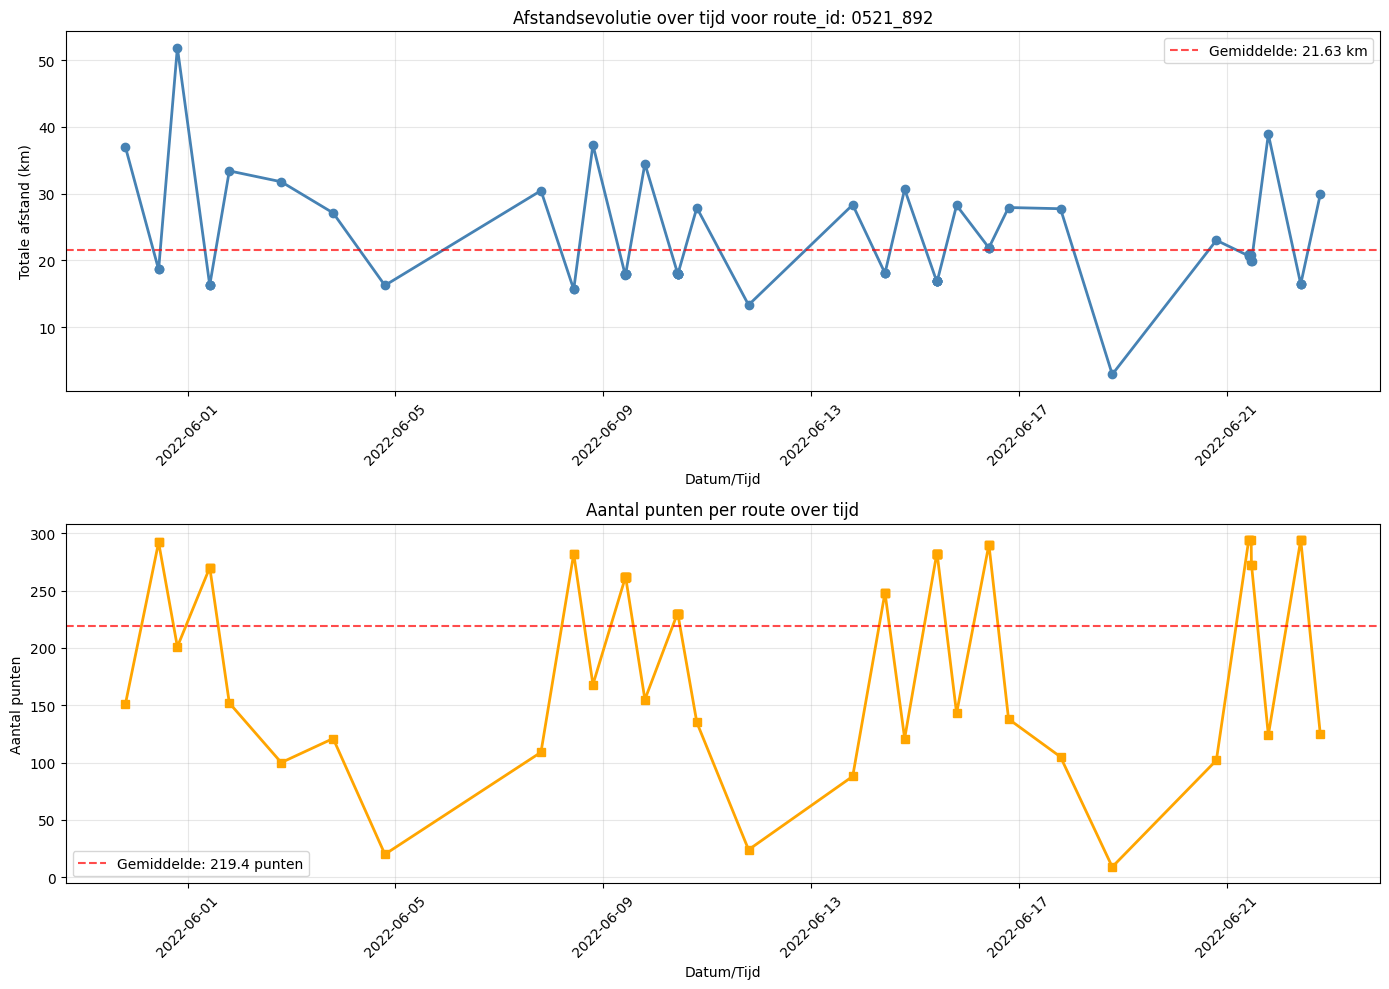


Detail van metingen:


,datetime,aantal_punten,totale_afstand_km
2308,2022-05-30 19:14:19,151,36.985886
3141,2022-05-31 10:33:53,292,18.649412
1508,2022-05-31 10:35:24,292,18.649412
1944,2022-05-31 19:14:54,201,51.851413
3494,2022-06-01 10:11:06,270,16.331622
3396,2022-06-01 10:12:20,270,16.331622
2273,2022-06-01 10:13:42,270,16.331622
3555,2022-06-01 19:14:14,152,33.404157
116,2022-06-02 19:13:21,100,31.776922
2569,2022-06-03 19:13:07,121,27.106946


In [ ]:

# Kies een route_id die meerdere keren voorkomt (over verschillende dates/times)
route_counts = route_afstanden.groupby('route_id').size().sort_values(ascending=False)
print(f"Top 10 route_ids met meeste metingen:")
print(route_counts.head(10))

# Selecteer de route_id met de meeste metingen
selected_route_id = route_counts.index[0]
print(f"\nGeselecteerde route_id: {selected_route_id}")

# Haal alle metingen op voor deze route_id
route_evolutie = route_afstanden[route_afstanden['route_id'] == selected_route_id].copy()

# Combineer date en time naar datetime (zorg dat ze strings zijn)
route_evolutie['datetime'] = pd.to_datetime(route_evolutie['date'].astype(str) + ' ' + route_evolutie['time'].astype(str))

# Sorteer op datetime
route_evolutie = route_evolutie.sort_values('datetime')

print(f"\nAantal metingen: {len(route_evolutie)}")
print(f"Periode: {route_evolutie['datetime'].min()} tot {route_evolutie['datetime'].max()}")
print(f"\nStatistieken afstand (km):")
print(route_evolutie['totale_afstand_km'].describe())

# Maak de visualisatie
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Totale afstand over tijd
ax1.plot(route_evolutie['datetime'], route_evolutie['totale_afstand_km'], 
         marker='o', linestyle='-', linewidth=2, markersize=6, color='steelblue')
ax1.set_xlabel('Datum/Tijd')
ax1.set_ylabel('Totale afstand (km)')
ax1.set_title(f'Afstandsevolutie over tijd voor route_id: {selected_route_id}')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Voeg gemiddelde lijn toe
gemiddelde_afstand = route_evolutie['totale_afstand_km'].mean()
ax1.axhline(y=gemiddelde_afstand, color='red', linestyle='--', alpha=0.7, 
           label=f'Gemiddelde: {gemiddelde_afstand:.2f} km')
ax1.legend()

# Plot 2: Aantal punten over tijd
ax2.plot(route_evolutie['datetime'], route_evolutie['aantal_punten'], 
         marker='s', linestyle='-', linewidth=2, markersize=6, color='orange')
ax2.set_xlabel('Datum/Tijd')
ax2.set_ylabel('Aantal punten')
ax2.set_title(f'Aantal punten per route over tijd')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Voeg gemiddelde lijn toe
gemiddelde_punten = route_evolutie['aantal_punten'].mean()
ax2.axhline(y=gemiddelde_punten, color='red', linestyle='--', alpha=0.7, 
           label=f'Gemiddelde: {gemiddelde_punten:.1f} punten')
ax2.legend()

plt.tight_layout()
plt.show()

# Toon ook een tabel met de data
print("\nDetail van metingen:")
display(route_evolutie[['datetime', 'aantal_punten', 'totale_afstand_km']].head(20))

Analyse periode: 2022-05-30 00:00:00 tot 2022-06-22 00:00:00
Totaal aantal routes: 4534
Gemiddeld aantal routes per dag: 226.7


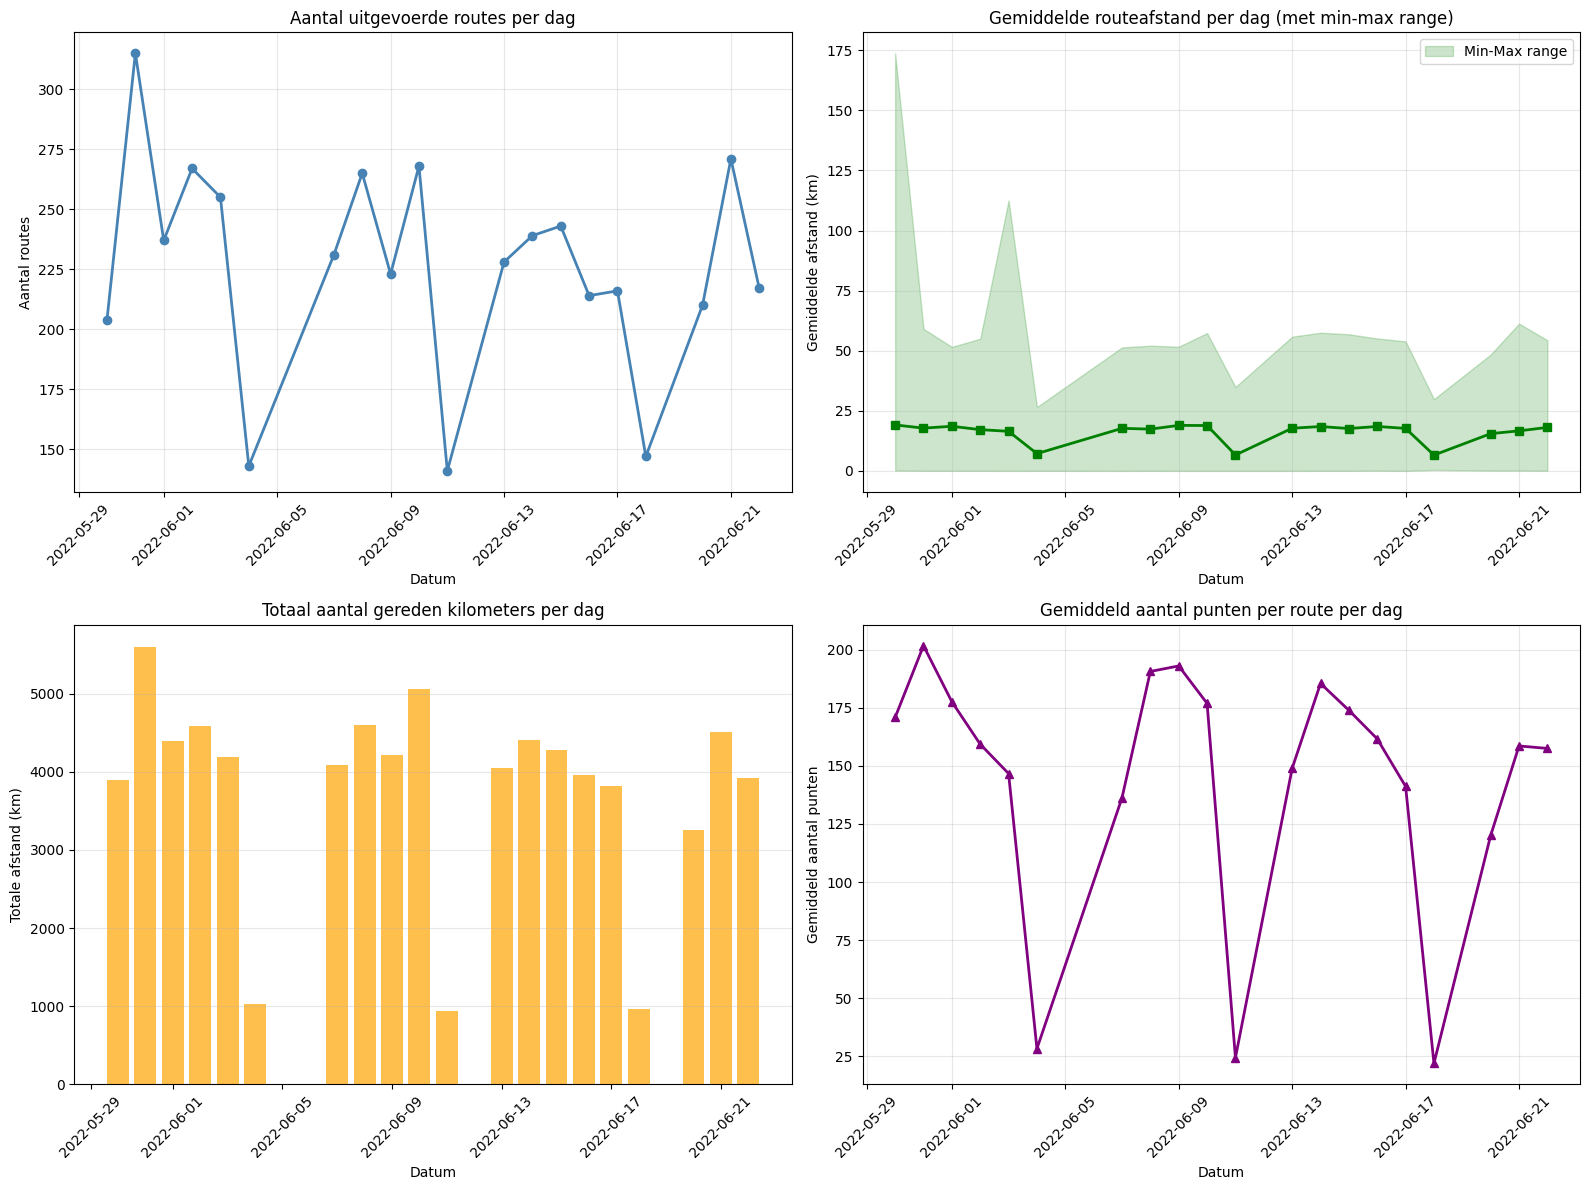


Dagelijkse statistieken (eerste 10 dagen):


,date_only,aantal_routes,gem_afstand_km,totaal_afstand_km,gem_punten,min_afstand_km,max_afstand_km
0,2022-05-30,204,19.114314,3899.319974,170.818627,0.105755,173.788013
1,2022-05-31,315,17.782093,5601.359452,201.666667,0.035252,59.110030
2,2022-06-01,237,18.550892,4396.561366,177.569620,0.035252,51.595410
3,2022-06-02,267,17.155371,4580.484037,159.303371,0.035252,54.977986
4,2022-06-03,255,16.453955,4195.758500,146.686275,0.000000,112.538607
5,2022-06-04,143,7.177951,1026.446939,28.342657,0.035252,26.565452
6,2022-06-07,231,17.694824,4087.504369,136.242424,0.000000,51.374533
7,2022-06-08,265,17.370042,4603.061207,190.600000,0.035252,52.088800
8,2022-06-09,223,18.926483,4220.605762,192.968610,0.000000,51.663330
9,2022-06-10,268,18.869867,5057.124424,176.854478,0.000000,57.341561



Overzicht statistieken:
Totaal gereden kilometers (alle routes): 75764.19 km
Gemiddelde afstand per route: 16.71 km
Gemiddeld aantal punten per route: 152.5


In [ ]:

# Voeg datetime toe aan alle routes
route_afstanden_tijd = route_afstanden.copy()
route_afstanden_tijd['datetime'] = pd.to_datetime(
    route_afstanden_tijd['date'].astype(str) + ' ' + route_afstanden_tijd['time'].astype(str)
)

# Groepeer op datum (zonder tijd) voor dagelijkse trends
route_afstanden_tijd['date_only'] = route_afstanden_tijd['datetime'].dt.date

# Bereken dagelijkse statistieken
daily_stats = route_afstanden_tijd.groupby('date_only').agg(
    aantal_routes=('id', 'count'),
    gem_afstand_km=('totale_afstand_km', 'mean'),
    totaal_afstand_km=('totale_afstand_km', 'sum'),
    gem_punten=('aantal_punten', 'mean'),
    min_afstand_km=('totale_afstand_km', 'min'),
    max_afstand_km=('totale_afstand_km', 'max')
).reset_index()

# Converteer date_only terug naar datetime voor plotting
daily_stats['date_only'] = pd.to_datetime(daily_stats['date_only'])

print(f"Analyse periode: {daily_stats['date_only'].min()} tot {daily_stats['date_only'].max()}")
print(f"Totaal aantal routes: {len(route_afstanden_tijd)}")
print(f"Gemiddeld aantal routes per dag: {daily_stats['aantal_routes'].mean():.1f}")

# Maak de visualisatie
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Aantal routes per dag
ax1.plot(daily_stats['date_only'], daily_stats['aantal_routes'], 
         marker='o', linestyle='-', linewidth=2, color='steelblue')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Aantal routes')
ax1.set_title('Aantal uitgevoerde routes per dag')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Gemiddelde afstand per dag
ax2.plot(daily_stats['date_only'], daily_stats['gem_afstand_km'], 
         marker='s', linestyle='-', linewidth=2, color='green')
ax2.fill_between(daily_stats['date_only'], 
                  daily_stats['min_afstand_km'], 
                  daily_stats['max_afstand_km'], 
                  alpha=0.2, color='green', label='Min-Max range')
ax2.set_xlabel('Datum')
ax2.set_ylabel('Gemiddelde afstand (km)')
ax2.set_title('Gemiddelde routeafstand per dag (met min-max range)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Plot 3: Totale gereden kilometers per dag
ax3.bar(daily_stats['date_only'], daily_stats['totaal_afstand_km'], 
        color='orange', alpha=0.7, width=0.8)
ax3.set_xlabel('Datum')
ax3.set_ylabel('Totale afstand (km)')
ax3.set_title('Totaal aantal gereden kilometers per dag')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Gemiddeld aantal punten per route per dag
ax4.plot(daily_stats['date_only'], daily_stats['gem_punten'], 
         marker='^', linestyle='-', linewidth=2, color='purple')
ax4.set_xlabel('Datum')
ax4.set_ylabel('Gemiddeld aantal punten')
ax4.set_title('Gemiddeld aantal punten per route per dag')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Toon statistieken
print("\nDagelijkse statistieken (eerste 10 dagen):")
display(daily_stats.head(10))

print("\nOverzicht statistieken:")
print(f"Totaal gereden kilometers (alle routes): {daily_stats['totaal_afstand_km'].sum():.2f} km")
print(f"Gemiddelde afstand per route: {route_afstanden_tijd['totale_afstand_km'].mean():.2f} km")
print(f"Gemiddeld aantal punten per route: {route_afstanden_tijd['aantal_punten'].mean():.1f}")